# 시계열 데이터 분석 _ 비트코인 시세 예측하기

In [2]:
# Data Source : http://www.blockchain.com/ko/charts/market-price?timespan=80days

import pandas as pd

# 학습 데이터셋을 불러옵니다. (3년치)
file_path = './train.csv'
bitcoin_df = pd.read_csv(file_path)
bitcoin_df.rename(columns = {'Timestamp' : 'day', 'market-price':'price'}, inplace = True)

# 실제 테스트 데이터셋을 불러옵니다. (예측할 7일)
test_file_path = './test.csv'
bitcoin_test_df = pd.read_csv(test_file_path)
bitcoin_test_df.rename(columns = {'Timestamp' : 'day', 'market-price':'price'}, inplace = True)

In [3]:
bitcoin_test_df

,day,price
0,2021-01-21 0:00,35538.98
1,2021-01-22 0:00,30797.88
2,2021-01-23 0:00,33002.38
3,2021-01-24 0:00,32099.74
4,2021-01-25 0:00,32276.84
5,2021-01-26 0:00,32243.26
6,2021-01-27 0:00,32541.80


In [4]:
bitcoin_test_df.shape

(7, 2)

In [5]:
bitcoin_df.head(10)

,day,price
0,2018-01-29 0:00,11742.33
1,2018-01-30 0:00,11186.12
2,2018-01-31 0:00,10082.52
3,2018-02-01 0:00,10204.00
4,2018-02-02 0:00,9098.27
5,2018-02-03 0:00,8852.73
6,2018-02-04 0:00,9224.62
7,2018-02-05 0:00,8202.06
8,2018-02-06 0:00,6925.46
9,2018-02-07 0:00,7712.37


In [6]:
bitcoin_df.tail(10)

,day,price
1085,2021-01-18 0:00,35793.01
1086,2021-01-19 0:00,36632.35
1087,2021-01-20 0:00,36020.13
1088,NaN,NaN
1089,NaN,NaN
1090,NaN,NaN
1091,NaN,NaN
1092,NaN,NaN
1093,NaN,NaN
1094,NaN,NaN


In [7]:
# 기본 정보를 출력합니다.
print('Shape : ',bitcoin_df.shape)
print('-------'*5)
print(bitcoin_df.info())

Shape :  (1095, 2)
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1088 non-null   object 
 1   price   1088 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.2+ KB
None


## <step1.> : 시계열 데이터 살펴보기

In [8]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다.
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2018-01-29,11742.33
2018-01-30,11186.12
2018-01-31,10082.52
2018-02-01,10204.00
2018-02-02,9098.27


In [9]:
bitcoin_df.describe()

,price
count,1088.000000
mean,9042.404099
std,5096.153842
min,3231.910000
25%,6504.125000
50%,8266.535000
75%,10147.247500
max,40670.250000


In [10]:
bitcoin_df.isnull().sum()

price    7
dtype: int64

In [11]:
bitcoin_df.shape

(1095, 1)

In [12]:
bitcoin_df.dropna(inplace=True)

In [13]:
bitcoin_df.shape

(1088, 1)

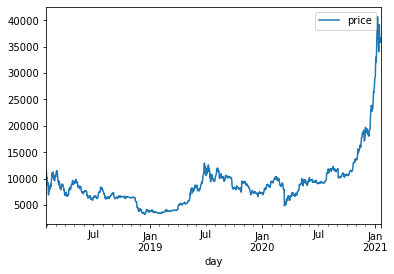

In [14]:
# 일자별 비트코인 시세를 시각화합니다.
import matplotlib.pyplot as plt

bitcoin_df.plot()
plt.rcParams["figure.figsize"] = (20,15) # plt 그래프 사이즈 조정
plt.show()

## <step2.> : 파이썬 라이브러리를 활용한 시세 예측

### [ARIMA 모델 활용하기]

#### ARIMA 모델 학습

---

AR

: 자동 회귀. Auto Regression.

데이터들의 경향성에서 데이터의 과거를 정보로 사용하는 개념.
    
현재의 상태는 이전 상태를 참고해서 계산된다.
    
이전의 값 자체를 참고하는 개념.
    
MA

: 이동 평균. Moving Average.

이전 항에서의 오차(차이)를 참고하는 개념.

I

: 차분, 즉 시계열 데이터의 불규칙성을 보정해주는 역할.

추세의 경향성까지 포함한 개념.

---

In [15]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action='ignore')

In [16]:
# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습힙니다.

model = ARIMA(bitcoin_df.price.values, order=(0,2,1))
model_fit = model.fit(trend='nc', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1086
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -8128.427
Method:                       css-mle   S.D. of innovations            430.184
Date:                Thu, 28 Jan 2021   AIC                          16260.853
Time:                        13:58:17   BIC                          16270.834
Sample:                             2   HQIC                         16264.631
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D2.y    -0.9840      0.006   -162.153      0.000      -0.996      -0.972
                                    Roots                                    
                  Real          Imaginary           M

#### 모델의 성능 & 예측 결과 시각화

* 학습한 모델이 학습 데이터에 대해서 예측한 결과만을 시각화합니다.

<AxesSubplot:>

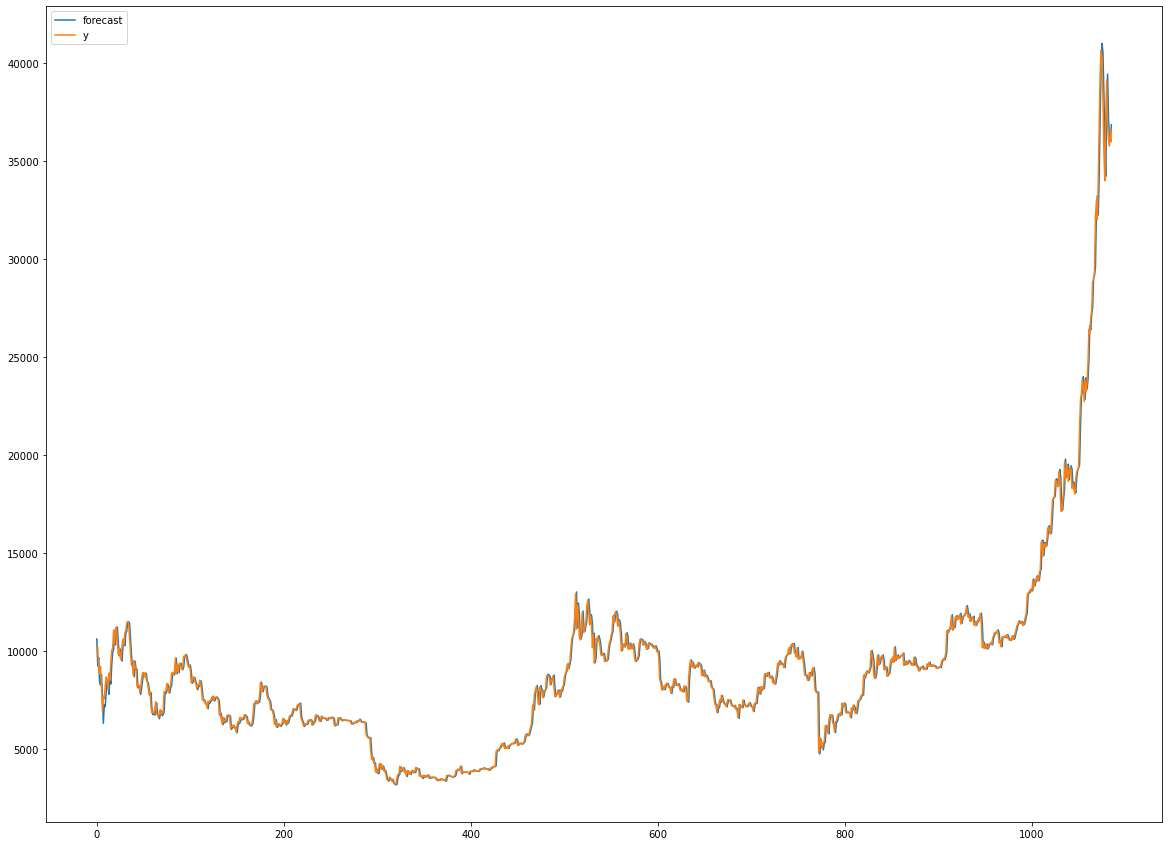

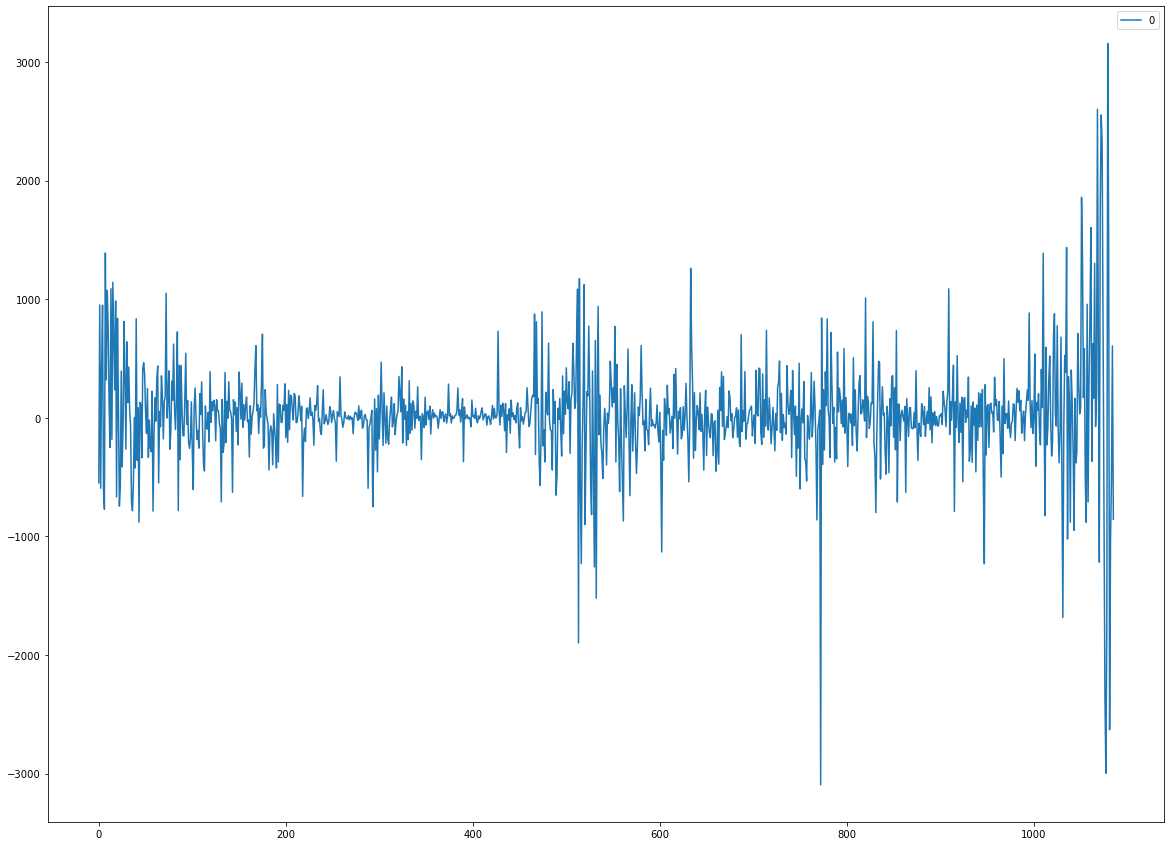

In [17]:
# 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
fig = model_fit.plot_predict()

# 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals = pd.DataFrame(model_fit.resid)

plt.rcParams["figure.figsize"] = (20,15) # plt 그래프 사이즈 조정
residuals.plot()

#### 실제 데이터와의 비교

* 예측 결과인 마지막 7일의 예측값을 실제 데이터와 비교해봅니다.

In [18]:
# 마지막 7일의 예측 데이터
pred_model = model_fit.forecast(steps=7)
pred = pred_model[0].tolist()
pred

[36249.11698431926,
 36478.10396863853,
 36707.09095295779,
 36936.077937277056,
 37165.06492159632,
 37394.051905915585,
 37623.03889023485]

In [19]:
# 실제 7일간 데이터
test = bitcoin_test_df.price.values
test

array([35538.98, 30797.88, 33002.38, 32099.74, 32276.84, 32243.26,
       32541.8 ])

In [20]:
# 시각화
pred_lower = []
pred_upper = []
for lower_upper in pred_model[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_lower.append(lower)
    pred_upper.append(upper)

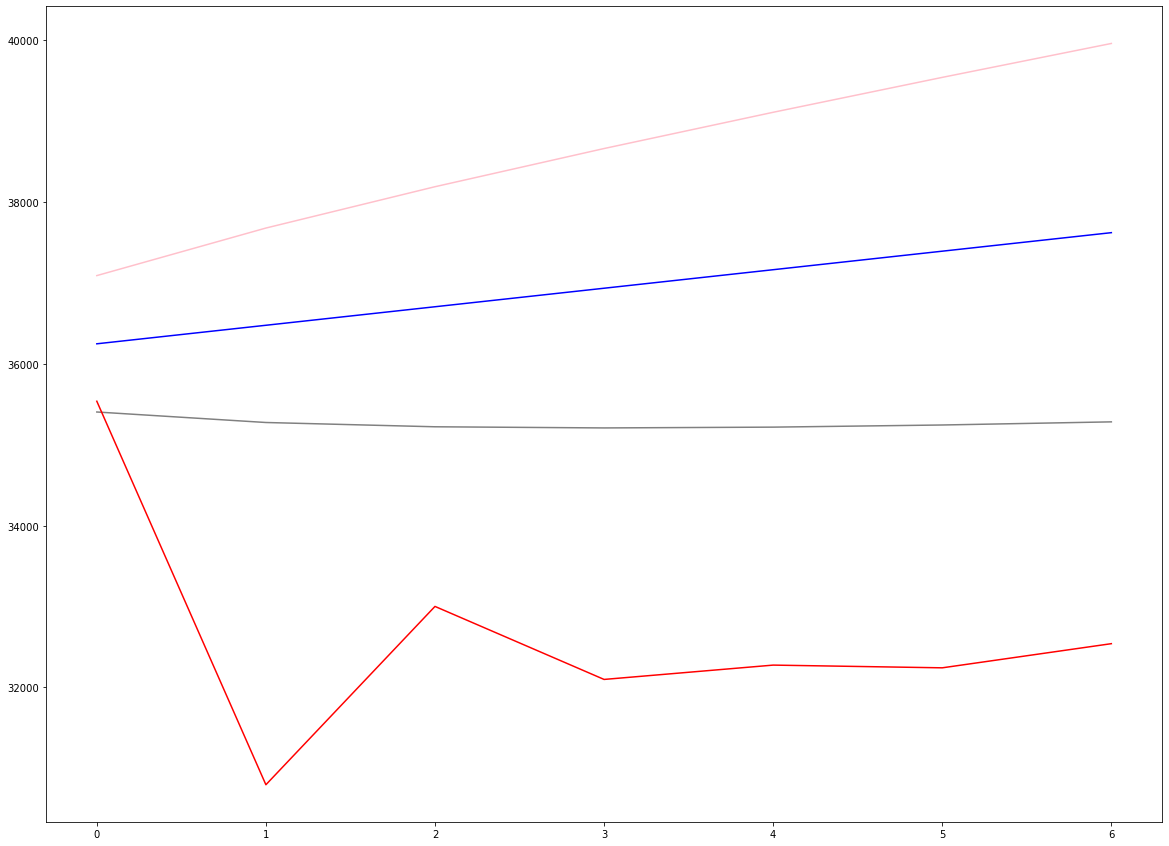

In [21]:
plt.plot(pred, color="blue") # 예측 가격
plt.plot(pred_lower, color = "gray") # 예측 최저가격
plt.plot(pred_upper, color = "pink") # 예측 최고가격
plt.plot(test, color = "red") # 실제가격

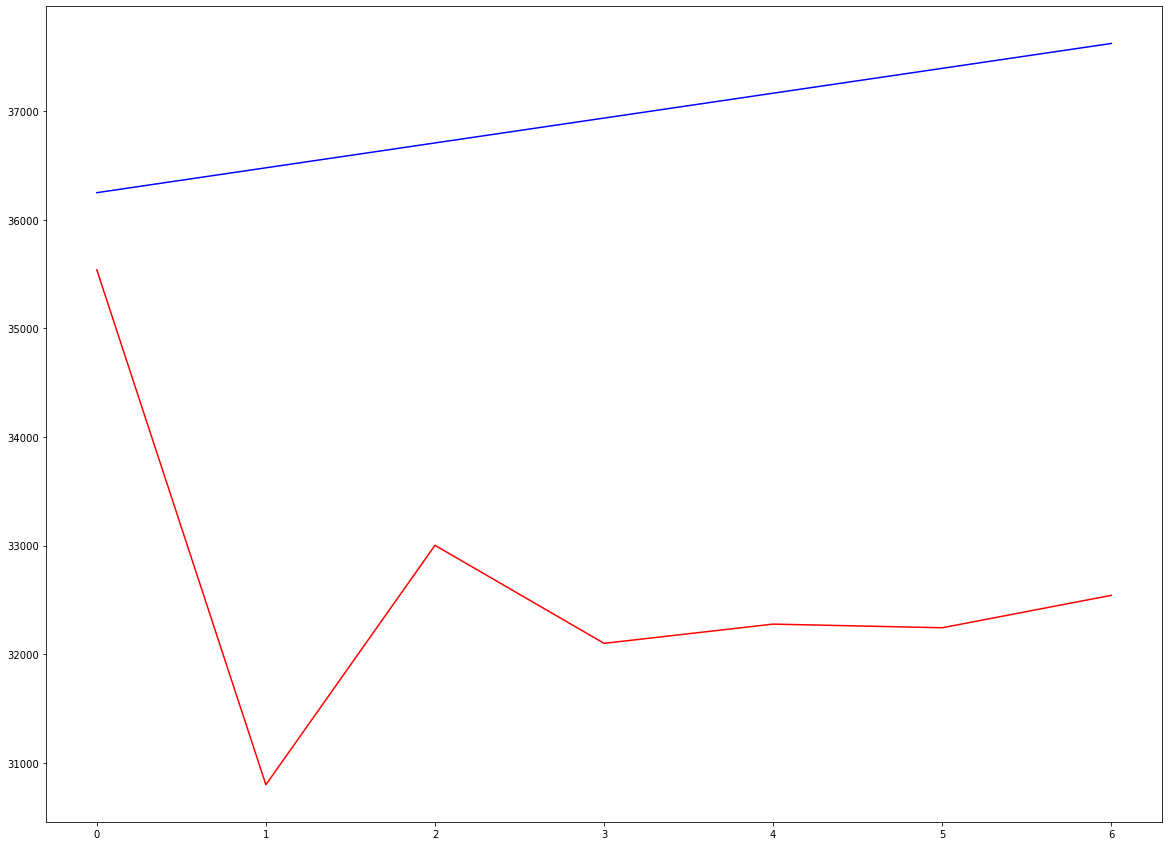

In [22]:
plt.plot(pred, color="blue") # 예측 가격
plt.plot(test, color = "red") # 실제 가격

In [23]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(pred, test))
print(rmse)

4568.974182472478


### [Facebook Prophet 모델 활용하기]

* 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.

* (env_name) conda install -c conda-forge fbprophet

* prophet의 input data columns는 'ds'와 'y'로 고정되어야 한다.

* seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미한다. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋다.
    
* changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측한다. 수치가 높을수록 overfitting에 가까워진다.

#### Prophet 모델 학습

In [24]:
from fbprophet import Prophet